# <font color=blue><div align="center">SDP - Systèmes de décision</div></font>

### <font color=blue><div align="center">18-12-2024</div></font>

- Kiyoshi Araki

- GabrielSouza

- Lucas Tramonte


## Libraries

In [65]:
import numpy as np
import pandas as pd 
import csv
from collections import OrderedDict
import matplotlib.pyplot as plt
import random
%matplotlib inline
from gurobipy import *

## Data processing

In [66]:
number_of_bricks = 22
number_of_sr = 4

# Current Structure of Sales Territories :
sr_assignments_current = [(1, 4,  [4, 5, 6, 7, 8, 15]),
          (2, 14, [10, 11, 12, 13, 14]),
          (3, 16, [9, 16, 17, 18]),
          (4, 22, [1, 2, 3, 19, 20, 21, 22])    
         ]

In [67]:
bricks_index_values_file = "Assets/Data/bricks_index_values.csv"

# brick_workloads : dict[int : float] : associates a brick identifier j with its new index value v_j.
brick_workloads = dict()

# Loading data
with open(bricks_index_values_file) as bricksIndexValuesFile:
    reader = csv.DictReader(bricksIndexValuesFile)
    for row in reader:
        b = int(row['brick'])
        brick_workloads[b] = float(row['index_value'])
        
brick_rp_distances_file = "Assets/Data/brick_rp_distances.csv"

# distance_sr_brick : dict[(int, int) : float] : associates with the pair (i, j) of RP and brick identifiers, the distance separating i's office from the j brick
distance_sr_brick = dict()

# Loading data
with open(brick_rp_distances_file) as brickRpDistancesFile:
    reader = csv.DictReader(brickRpDistancesFile)
    for row in reader:
        b = int(row['brick'])
        for rpId in range(1, number_of_sr + 1):
            distance_sr_brick[(rpId, b)] = float(row[f'rp{rpId}'])

In [68]:
SR_set = set()
Center_Brick_Set = set()
Brick_List = list()

for rp, center_brick, bricks_assigned in sr_assignments_current:
    print(f'SR {rp}', f'Center Brick {center_brick}', f'Bricks assigned', *bricks_assigned)
    SR_set.add(rp)
    Center_Brick_Set.add(center_brick)
    Brick_List += bricks_assigned

Brick_List.sort()
assert Brick_List == list(range(1, number_of_bricks + 1))
assert Center_Brick_Set - set(Brick_List) == set()
assert SR_set == set(range(1, number_of_sr + 1))

SR 1 Center Brick 4 Bricks assigned 4 5 6 7 8 15
SR 2 Center Brick 14 Bricks assigned 10 11 12 13 14
SR 3 Center Brick 16 Bricks assigned 9 16 17 18
SR 4 Center Brick 22 Bricks assigned 1 2 3 19 20 21 22


In [69]:
assert brick_workloads[4] == 0.1516
assert brick_workloads[22] == 0.2531
assert distance_sr_brick[(1, 1)] == 16.16
assert distance_sr_brick[(2, 15)] == 2.32
assert distance_sr_brick[(3, 16)] == 0.00

# Step 1

### Formulate and implement two mono-objective linear optimization models to solve the assignment problem using a distance and a disruption objective. Solve the instance with 22 Bricks and 4 Sales Representatives

Workload of each SR in the current solution for the new $v_j$ index values

In [70]:
SR = {} 
for j in range(0, number_of_sr):
    LinExpr = quicksum(brick_workloads[i] for i in sr_assignments_current[j][2]) 
    SR[f'SR{j+1}'] = round(LinExpr.getValue(),3)
    
SR_data = pd.DataFrame(list(SR.items()), columns=['i', 'Workload'])
SR_data

,i,Workload
0,SR1,0.951
1,SR2,1.338
2,SR3,0.705
3,SR4,1.007


In [71]:
# Define problem variables 

# -- Model initialization --
m = Model("rendu")

# Xij : dict[(int, int) : Var] : Assignment of brig j to SR office i
Xij = {(i, j) : m.addVar(vtype = GRB.BINARY, name=f'x_{i}_{j}') for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)}

Constraints

- Each brick is assigned to a single SR

$$\sum_{i = 1}^{4} x_{ij} = 1 \;\;\;\; \text{for all $j = 1 \dots 22$} \;\;\;$$

In [72]:
CONSTR = {j : m.addConstr(quicksum(Xij[(i,j)] for i in range(1, number_of_sr + 1)) == 1, name = f'Constr{j}') for j in range(1, number_of_bricks + 1)}

- Each SR has a workload in the interval $[0.8, 1.2]$.

$$\sum_{j = 1}^{22} x_{ij}v_{j} \leq 1.2 \;\;\;\; \text{for all $i = 1\dots 4$} \;\;\;$$

$$\sum_{j = 1}^{22} x_{ij}v_{j} \geq 0.8 \;\;\;\; \text{for all $i = 1\dots 4$} \;\;\;$$

In [73]:
CHARGEINF = {i : m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks + 1)) >= 0.8, name = f'Charge_inf{i}') for i in range(1, number_of_sr + 1)}
CHARGESUP = {i : m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks + 1)) <= 1.2, name = f'Charge_sup{i}') for i in range(1, number_of_sr + 1)}

Define the objective of minimizing the total travel distance of all SRs.

$$\text{Minimize} \;\;\; \sum_{i = 1}^{4}\sum_{j = 1}^{22} x_{ij}d_{ij}$$

In [74]:
z1 = quicksum(Xij[(i,j)]*distance_sr_brick[(i,j)] for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1))
# -- Objective function added --
m.setObjective(z1, GRB.MINIMIZE)
m.params.outputflag = 0 # mute mode

# -- Model update --
m.update()
display(m)

<gurobi.Model MIP instance rendu: 30 constrs, 88 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [75]:
# -- Resolution --
m.optimize()

# Objective function value
print(f'z* = {round(m.objVal, 3)} km')

print('\n')

#Measure load and distance
Distance = {i : quicksum([distance_sr_brick[(i, j)]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}
Charge  = {i : quicksum([brick_workloads[j]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}

df = pd.DataFrame([
    {
        "SR": SR,
        "SR Office": SR_OFFICE,
        "Bricks allocated": [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1],
        "Workload": round(Charge[SR].getValue(), 3),
        "Distance covered (km)": round(Distance[SR].getValue(),3),
    }
    for SR, SR_OFFICE, BRICKS in sr_assignments_current 
])

df

z* = 154.62 km




,SR,SR Office,Bricks allocated,Workload,Distance covered (km)
0,1,4,"[4, 5, 6, 7, 8, 9, 12, 19, 20]",1.038,64.37
1,2,14,"[11, 13, 14, 18]",1.045,7.56
2,3,16,"[10, 15, 16, 17]",1.115,6.56
3,4,22,"[1, 2, 3, 21, 22]",0.803,76.13


Define the objective function to minimize the weighted disturbance in percent (%).

$$\text{Minimize} \;\;\; 100\frac{\sum_{i = 1}^{4} \sum_{j = 1}^{22} x_{ij}v_j(1 - x_{ij}^*)}{\sum_{j = 1}^{22} v_j}$$

current assignment:
$$ x_{ij}^*  \;\;\; $$     

In [76]:
current_assignment = {(i, j) : 0 for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)}
for SR, BSR_OFFICE, BRICKS in sr_assignments_current:
    value = 0
    for brick in BRICKS:
        current_assignment[(SR, brick)] = 1
        value += brick_workloads[brick]
        

z2 = 100 * quicksum([brick_workloads[j]*(1 - current_assignment[(i, j)])*Xij[(i, j)] for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)]) / sum(brick_workloads.values())

print("The value of the weighted disturbance generated by the optimal solution is {} %.".format(round(z2.getValue(),3)))

The value of the weighted disturbance generated by the optimal solution is 30.138 %.


In [77]:
m.setObjective(z2, GRB.MINIMIZE)
m.params.outputflag = 0 
m.update()
m.optimize()

print(f' we obtain z* = {round(m.objVal, 3)} %  of the total disturbance ')

 we obtain z* = 4.24 %  of the total disturbance 


In [78]:
Distance = {i : quicksum([distance_sr_brick[(i, j)]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}
Charge  = {i : quicksum([brick_workloads[j]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}

df = pd.DataFrame([
    {
        "SR": SR,
        "SR Office": SR_OFFICE,
        "Bricks allocated": [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1],
        "Workload": round(Charge[SR].getValue(), 3),
        "Distance covered (km)": round(Distance[SR].getValue(),3),
    }
    for SR, SR_OFFICE, BRICKS in sr_assignments_current 
])

df


,SR,SR Office,Bricks allocated,Workload,Distance covered (km)
0,1,4,"[4, 5, 6, 7, 8, 15]",0.951,19.30
1,2,14,"[10, 13, 14]",1.168,7.79
2,3,16,"[9, 11, 12, 16, 17, 18]",0.874,37.06
3,4,22,"[1, 2, 3, 19, 20, 21, 22]",1.007,124.74


In [79]:
print(df['Distance covered (km)'].sum(), 'km')

188.89 km


Reducing the weighted loss increases the total distance covered by the RP:

Minimization of total distance = (154.62, 30.138 )


Minimization of weighted disturbance = (188.89, 4.24)

### Implement the epsilon-constraint scheme to compute the set of all non-dominated solutions

$$\epsilon = 0.001$$

$$\alpha = 0$$

In [80]:
columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR_OFFICE", "Bricks Allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)


alpha = 0
epsilon = 0.001 

EpsilonDict = dict()

m.setObjective(z1 + alpha*z2, GRB.MINIMIZE)
m.params.outputflag = 0 
m.update()
m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = { 
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, SR_OFFICE, BRICKS in sr_assignments_current: 
        row["SR"] = SR
        row["SR OFFICE"] = SR_OFFICE
        row["Bricks allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_4080\578898622.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR_OFFICE,Bricks Allocated,Workload,Distance (km),SR OFFICE,Bricks allocated
0,0,154.62,30.138,1,NaN,NaN,1.038,64.37,4.0,"[4, 5, 6, 7, 8, 9, 12, 19, 20]"
1,0,154.62,30.138,2,NaN,NaN,1.045,7.56,14.0,"[11, 13, 14, 18]"
2,0,154.62,30.138,3,NaN,NaN,1.115,6.56,16.0,"[10, 15, 16, 17]"
3,0,154.62,30.138,4,NaN,NaN,0.803,76.13,22.0,"[1, 2, 3, 21, 22]"
4,1,154.64,28.068,1,NaN,NaN,0.955,42.38,4.0,"[4, 5, 6, 7, 8, 9, 19, 20]"
...,...,...,...,...,...,...,...,...,...,...
75,18,188.13,5.675,4,NaN,NaN,1.007,124.74,22.0,"[1, 2, 3, 19, 20, 21, 22]"
76,19,188.89,4.240,1,NaN,NaN,0.951,19.30,4.0,"[4, 5, 6, 7, 8, 15]"
77,19,188.89,4.240,2,NaN,NaN,1.168,7.79,14.0,"[10, 13, 14]"
78,19,188.89,4.240,3,NaN,NaN,0.874,37.06,16.0,"[9, 11, 12, 16, 17, 18]"


## Compute and represent the corresponding sets of non-dominated solutions for the 4x22 problem, with interval workload constraints [0.8, 1.2], [0.85, 1.15], and [0.9, 1.1],

In [81]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee)) # aggregating lists
Liste_solutions_efficaces = list(OrderedDict.fromkeys(solutions_efficaces)) # maintains the sequence in which keys are added
Liste_solutions_efficaces

[(154.62, 30.138),
 (154.64, 28.068),
 (154.99, 24.917),
 (160.58, 24.062),
 (160.71, 22.425),
 (163.35, 21.062),
 (164.57, 20.695),
 (164.64, 19.895),
 (165.9, 14.66),
 (166.44, 12.49),
 (167.21, 11.422),
 (168.14, 10.775),
 (168.9, 9.34),
 (172.93, 8.93),
 (173.86, 8.282),
 (174.62, 6.848),
 (183.17, 6.732),
 (187.2, 6.323),
 (188.13, 5.675),
 (188.89, 4.24)]

We can see that solution 13 is not efficient, because solution 14 strictly dominates it:

|     13 	            |            (168.91, 9.707)             	|

In [82]:
Liste_solutions_efficaces.pop(12) #remove solution 13 from the list, index starts from zero
Liste_solutions_efficaces

[(154.62, 30.138),
 (154.64, 28.068),
 (154.99, 24.917),
 (160.58, 24.062),
 (160.71, 22.425),
 (163.35, 21.062),
 (164.57, 20.695),
 (164.64, 19.895),
 (165.9, 14.66),
 (166.44, 12.49),
 (167.21, 11.422),
 (168.14, 10.775),
 (172.93, 8.93),
 (173.86, 8.282),
 (174.62, 6.848),
 (183.17, 6.732),
 (187.2, 6.323),
 (188.13, 5.675),
 (188.89, 4.24)]

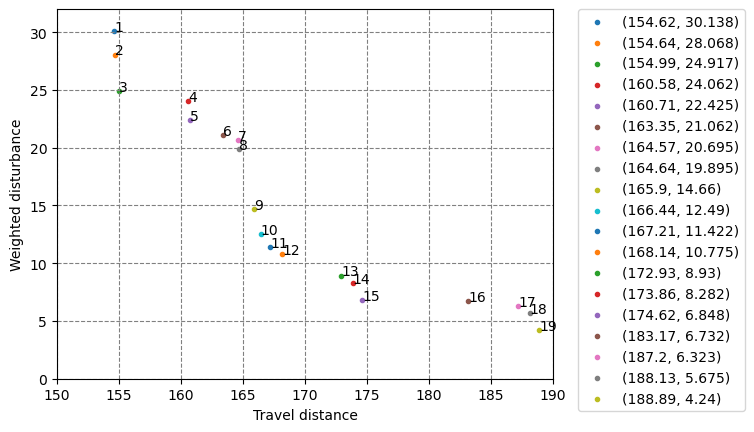

In [83]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

<font color="blue">
  <div align="center">There are exactly</div>
</font>

<div align="center">6 supported solutions.</div>
<div align="justify">These are 1, 2, 3, 13, 16, 20</div>

It is important to note that the old solution 13 was removed, but index 13 was reassigned to the next solution.  
To avoid confusion, the solution `(168.91, 9.707)` is not efficient and has not been included.  
The solution that moved from index 14 to index 13 is `(168.9, 9.34)`, and it is a supported solution.


Calculate the set of non-dominated solutions if we now limit the workload of each SR to the interval $[0.9, 1.1]$.

In [84]:
for cs in CHARGESUP.values():
    cs.RHS = 1.1
    
for ci in CHARGEINF.values():
    ci.RHS = 0.9

for e in EpsilonDict.values():
    m.remove(e)
    
m.update()

columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR_OFFICE", "Bricks Allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)

m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = {
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, BUREAU_SR, BRICKS in sr_assignments_current:
        row["SR"] = SR
        row["SR_OFFICE"] = SR_OFFICE
        row["Bricks Allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_4080\942549307.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR_OFFICE,Bricks Allocated,Workload,Distance (km)
0,0,162.43,28.352,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
1,0,162.43,28.352,2,22,"[11, 13, 14, 17]",1.073,9.19
2,0,162.43,28.352,3,22,"[10, 15, 16, 18]",1.087,7.02
3,0,162.43,28.352,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
4,1,162.81,24.862,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
5,1,162.81,24.862,2,22,"[10, 14]",1.071,4.51
6,1,162.81,24.862,3,22,"[11, 13, 15, 16, 17, 18]",1.089,12.08
7,1,162.81,24.862,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
8,2,171.36,24.747,1,22,"[4, 5, 6, 7, 8, 9, 12, 20]",0.933,53.24
9,2,171.36,24.747,2,22,"[10, 14]",1.071,4.51


In [85]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee))
Liste_solutions_efficaces_q12 = list(OrderedDict.fromkeys(solutions_efficaces))
Liste_solutions_efficaces_q12

[(162.43, 28.352),
 (162.81, 24.862),
 (171.36, 24.747),
 (171.62, 12.168),
 (172.39, 11.1),
 (172.93, 8.93),
 (181.48, 8.815),
 (186.66, 8.492),
 (187.18, 8.393),
 (187.2, 6.323)]

Represent these solutions in bi-criteria space.

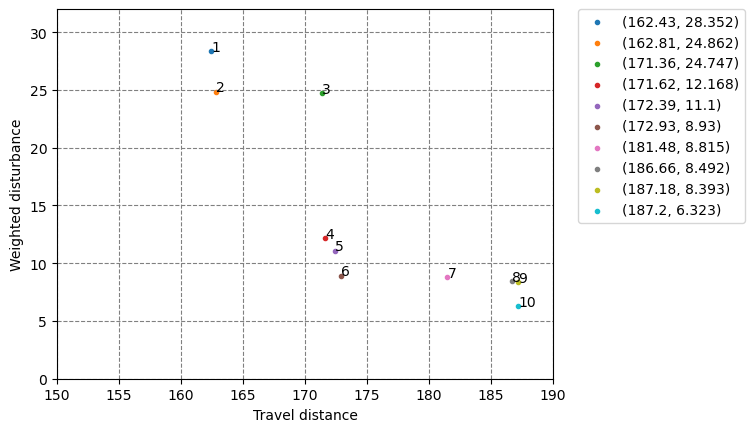

In [86]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces_q12]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces_q12]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

Calculate the set of non-dominated solutions if we now limit the workload of each SR to the interval $[0.85, 1.15]$.

In [87]:
for cs in CHARGESUP.values():
    cs.RHS = 1.15
    
for ci in CHARGEINF.values():
    ci.RHS = 0.85

for e in EpsilonDict.values():
    m.remove(e)
    
m.update()

columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR_OFFICE", "Bricks Allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)

m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = {
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, BUREAU_SR, BRICKS in sr_assignments_current:
        row["SR"] = SR
        row["SR_OFFICE"] = SR_OFFICE
        row["Bricks Allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_4080\3950715657.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR_OFFICE,Bricks Allocated,Workload,Distance (km)
0,0,160.34,27.645,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
1,0,160.34,27.645,2,22,"[11, 13, 14, 18]",1.045,7.56
2,0,160.34,27.645,3,22,"[10, 15, 16, 17]",1.115,6.56
3,0,160.34,27.645,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
4,1,160.36,25.575,1,22,"[4, 5, 6, 7, 8, 9, 19]",0.855,24.89
5,1,160.36,25.575,2,22,"[11, 12, 13, 14, 18]",1.127,29.57
6,1,160.36,25.575,3,22,"[10, 15, 16, 17]",1.115,6.56
7,1,160.36,25.575,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
8,2,162.81,24.862,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
9,2,162.81,24.862,2,22,"[10, 14]",1.071,4.51


In [88]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee))
Liste_solutions_efficaces_q12 = list(OrderedDict.fromkeys(solutions_efficaces))
Liste_solutions_efficaces_q12

[(160.34, 27.645),
 (160.36, 25.575),
 (162.81, 24.862),
 (169.11, 24.508),
 (171.6, 14.238),
 (171.62, 12.168),
 (172.14, 12.068),
 (172.16, 9.998),
 (172.93, 8.93),
 (181.48, 8.815),
 (186.43, 7.39),
 (187.2, 6.323)]

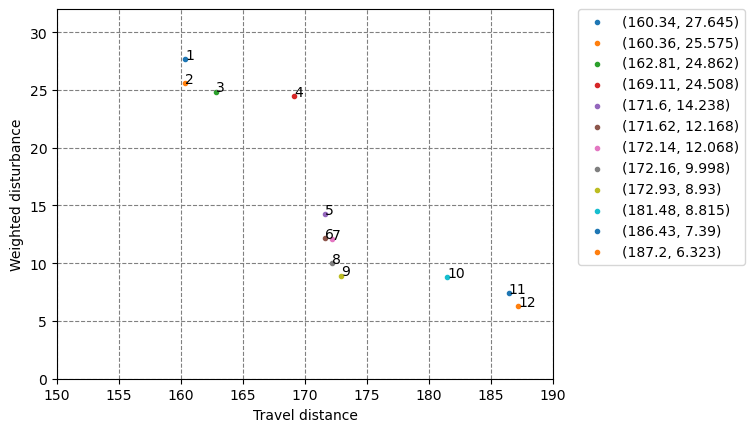

In [89]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces_q12]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces_q12]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

## Check how your model scales up with the instance with 10 SRs and 100 zones

# Synthetic Data Generation

In [90]:
import random
import numpy as np

number_of_sr = 10
number_of_bricks = 100
workload_lower = 0.8
workload_upper = 1.2

# We want total workload ~10.
# Each brick ~0.1 workload on average.
# We'll randomly pick workloads from [0.09, 0.11] to ensure total is close to 10.
brick_workloads = {
    j: float(np.random.uniform(0.09, 0.11)) 
    for j in range(1, number_of_bricks+1)
}

# Check total workload
total_workload = sum(brick_workloads.values())
print("Total workload:", total_workload)  # Should be close to ~10

# Distances remain random, that shouldn't cause feasibility issues as long as assignments are flexible.
distance_sr_brick = {
    (i, j): float(np.random.uniform(0.0, 100.0))
    for i in range(1, number_of_sr+1)
    for j in range(1, number_of_bricks+1)
}



Total workload: 9.994131219303574


In [91]:
# For simplicity, assume a current assignment as the previous solution

current_assignment = {(i, j): 0 for i in range(1, number_of_sr+1) 
                                for j in range(1, number_of_bricks+1)}
old_assignment_list = np.array_split(range(1, number_of_bricks+1), number_of_sr)
for sr_id, bricks_list in enumerate(old_assignment_list, start=1):
    for b in bricks_list:
        current_assignment[(sr_id, b)] = 1


# Model Building

In [92]:
m = Model("scaled_instance")

# Decision variables: Xij = 1 if brick j assigned to SR i
Xij = {(i, j): m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")
       for i in range(1, number_of_sr+1)
       for j in range(1, number_of_bricks+1)}

m.update()

# Constraints:
# 1. Every brick is assigned to exactly one SR
for j in range(1, number_of_bricks+1):
    m.addConstr(sum(Xij[(i, j)] for i in range(1, number_of_sr+1)) >= 1, 
                name=f"assign_{j}")

# 2. Workload constraints:
for i in range(1, number_of_sr+1):
    m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks+1)) >= workload_lower, 
                name=f"workload_lower_{i}")
    m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks+1)) <= workload_upper, 
                name=f"workload_upper_{i}")

m.update()

# Define Objectives

In [93]:
# Objective 1: Minimize total travel distance
z1 = quicksum(Xij[(i,j)] * distance_sr_brick[(i,j)] for i in range(1, number_of_sr+1) 
                                          for j in range(1, number_of_bricks+1))

# Objective 2: Minimize weighted disturbance:
# Disturbance = 100 * sum_over_i,j [v_j * (1 - x_{ij}^*) * Xij] / sum_of_vj
sum_vj = sum(brick_workloads.values())
z2 = 100 * (quicksum(brick_workloads[j]*(1 - current_assignment[(i,j)])*Xij[(i,j)]
                     for i in range(1, number_of_sr+1) 
                     for j in range(1, number_of_bricks+1)) / sum_vj)

# For demonstration, start with minimizing distance (z1):
m.setObjective(z1, GRB.MINIMIZE)

# Solve Model

In [94]:
m.Params.OutputFlag = 1  # Set to 1 to see log, 0 to mute
m.optimize()

# Print Results
if m.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    print(f"Objective (Distance): {m.objVal:.2f}")

    # Compute workloads and distances
    Distance = {i : sum(distance_sr_brick[(i,j)]*Xij[(i,j)].X for j in range(1, number_of_bricks+1))
                for i in range(1, number_of_sr+1)}
    Charge  = {i : sum(brick_workloads[j]*Xij[(i,j)].X for j in range(1, number_of_bricks+1))
                for i in range(1, number_of_sr+1)}

    solution_df = pd.DataFrame([
        {
            "SR": i,
            "Bricks Allocated": [j for j in range(1, number_of_bricks+1) if Xij[(i,j)].X > 0.5],
            "Workload": Charge[i],
            "Distance (km)": Distance[i],
        }
        for i in range(1, number_of_sr+1)
    ])
    print("\nSolution Allocation:")
    print(solution_df)

    # Compute disturbance measure for this solution
    disturbance_val = z2.getValue()
    print(f"\nWeighted Disturbance: {disturbance_val:.2f}%")

else:
    print("No optimal solution found. Status code:", m.status)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 120 rows, 1000 columns and 3000 nonzeros
Model fingerprint: 0x8ec33fe5
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [9e-02, 1e+00]
  Objective range  [7e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 4908.1318773
Presolve time: 0.00s
Presolved: 120 rows, 1000 columns, 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)
Found heuristic solution: objective 3337.4821580

Root relaxation: objective 9.829135e+02, 154 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   

# Decision Variables
                                                                  

$$
x_{ij} \in [0,1] \quad (\text{continuous})
$$

### Interpretation

We can assign a fraction  x_{ij} of brick  (j) to SR (i) , as long as the total assignment for each brick sums to 1:

$$
\sum_{i = 1}^{4} x_{ij} = 1 \quad \text{for all } j = 1, \dots, 22
$$

This means the “workload” of each brick \(j\) can be split among the SRs, but must be fully allocated.


In [95]:
def build_partial_model(objective="distance"):
    """
    Builds a Gurobi model that allows fractional assignments of bricks to SRs.
    objective : "distance" or "disturbance"
    Returns the model and the X_ij variables (dict).
    """
    # Create new model
    m = Model("partial_assignment")

    # Variables: X_ij in [0,1]
    X_ij = {
      (i, j): m.addVar(vtype=GRB.CONTINUOUS, 
                       lb=0.0, 
                       ub=1.0, 
                       name=f"X_{i}_{j}")
      for i in range(1, number_of_sr+1)
      for j in range(1, number_of_bricks+1)
    }

    # 2.1. Sum of fractions = 1 for each brick
    for j in range(1, number_of_bricks+1):
        m.addConstr(
            quicksum(X_ij[(i,j)] for i in range(1, number_of_sr+1)) == 1,
            name=f"assign_{j}"
        )

    # 2.2. Workload constraints
    for i in range(1, number_of_sr+1):
        m.addConstr(
            quicksum(X_ij[(i,j)] * brick_workloads[j] for j in range(1, number_of_bricks+1)) >= lower_workload,
            name=f"lower_{i}"
        )
        m.addConstr(
            quicksum(X_ij[(i,j)] * brick_workloads[j] for j in range(1, number_of_bricks+1)) <= upper_workload,
            name=f"upper_{i}"
        )

    # 3. Objective
    if objective == "distance":
        # Minimize total travel distance
        z_distance = quicksum(
            X_ij[(i,j)] * distance_sr_brick[(i,j)]
            for i in range(1, number_of_sr+1)
            for j in range(1, number_of_bricks+1)
        )
        m.setObjective(z_distance, GRB.MINIMIZE)

    elif objective == "disturbance":
        # Weighted disturbance
        total_workload = sum(brick_workloads.values())
        z_disturb = 100 * quicksum(
            brick_workloads[j] * (1 - current_assignment[(i,j)]) * X_ij[(i,j)]
            for i in range(1, number_of_sr+1)
            for j in range(1, number_of_bricks+1)
        ) / total_workload

        m.setObjective(z_disturb, GRB.MINIMIZE)

    else:
        raise ValueError("Objective must be 'distance' or 'disturbance'.")

    return m, X_ij


# 3) SOLVE PARTIAL MODELS

In [96]:
lower_workload = 0.8
upper_workload = 1.2

# 3.1 Minimizing distance with partial assignments
partial_dist_model, X_partial_dist = build_partial_model("distance")
partial_dist_model.setParam("OutputFlag", 0)  # Mute Gurobi logs if desired
partial_dist_model.optimize()

# 3.2 Minimizing disturbance with partial assignments
partial_disturb_model, X_partial_disturb = build_partial_model("disturbance")
partial_disturb_model.setParam("OutputFlag", 0)
partial_disturb_model.optimize()

############################
# 4) EXTRACT RESULTS
############################

def extract_results(model, X_var):
    """
    Returns total distance, total disturbance, and SR loads 
    from a solved partial-assignment model.
    """
    # Compute total distance
    dist = 0.0
    for (i,j), var in X_var.items():
        dist += var.X * distance_sr_brick[(i,j)]

    # Compute total disturbance
    total_w = sum(brick_workloads.values())
    disturb_num = 0.0
    for (i,j), var in X_var.items():
        disturb_num += brick_workloads[j] * (1 - current_assignment[(i,j)]) * var.X
    disturb = 100.0 * disturb_num / total_w

    # Compute each SR's total workload
    sr_loads = {}
    for i in range(1, number_of_sr+1):
        sr_loads[i] = sum(
            brick_workloads[j]*X_var[(i,j)].X 
            for j in range(1, number_of_bricks+1)
        )

    return dist, disturb, sr_loads

partial_dist_dist, partial_dist_disturb, partial_dist_loads = extract_results(partial_dist_model, X_partial_dist)
partial_disb_dist, partial_disb_disturb, partial_disb_loads = extract_results(partial_disturb_model, X_partial_disturb)

print("=== Partial Assignment - Min Distance ===")
print(f"Total Distance:    {partial_dist_dist:.3f}")
print(f"Weighted Disturb.: {partial_dist_disturb:.3f} %")
print("SR Workloads:", partial_dist_loads)

print("\n=== Partial Assignment - Min Disturbance ===")
print(f"Total Distance:    {partial_disb_dist:.3f}")
print(f"Weighted Disturb.: {partial_disb_disturb:.3f} %")
print("SR Workloads:", partial_disb_loads)

=== Partial Assignment - Min Distance ===
Total Distance:    982.914
Weighted Disturb.: 88.056 %
SR Workloads: {1: 1.0931376320606756, 2: 1.2, 3: 0.8, 4: 1.1277998364429147, 5: 0.8000000000000002, 6: 0.9904030833942702, 7: 1.2, 8: 0.9825866081300415, 9: 1.0002040592756714, 10: 0.8000000000000002}

=== Partial Assignment - Min Disturbance ===
Total Distance:    5111.339
Weighted Disturb.: 0.000 %
SR Workloads: {1: 1.0199311867461351, 2: 0.9797578978992822, 3: 1.006142764052495, 4: 1.0373037966283791, 5: 0.9933477546402774, 6: 1.0133698062331518, 7: 0.9900293521056013, 8: 0.9870913365452821, 9: 0.9899151296558014, 10: 0.9772421947971682}


# Comparison and Plotting

,Model Type,Distance,Disturbance
0,Integral - Dist,154.620000,30.138000
1,Integral - Disturb,188.890000,4.240000
2,Partial - Dist,982.913548,88.055666
3,Partial - Disturb,5111.338972,0.000000


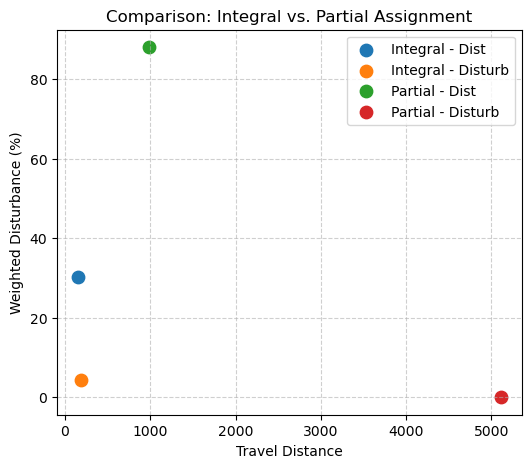

In [97]:
# Suppose from previous runs, we got integral min-distance solution:
int_min_dist_distance = 154.62
int_min_dist_disturb  = 30.138

# Suppose from previous runs, we got integral min-disturbance solution:
int_min_disb_distance = 188.89
int_min_disb_disturb  = 4.24

# Now from the partial model:
part_min_dist_distance = partial_dist_dist   # from partial-assignment (min distance)
part_min_dist_disturb  = partial_dist_disturb
part_min_disb_distance = partial_disb_dist
part_min_disb_disturb  = partial_disb_disturb

# Make a DataFrame of these four solutions:
compare_df = pd.DataFrame({
    "Model Type": ["Integral - Dist", "Integral - Disturb", 
                   "Partial - Dist",  "Partial - Disturb"],
    "Distance":   [int_min_dist_distance, int_min_disb_distance, 
                   part_min_dist_distance, part_min_disb_distance],
    "Disturbance":[int_min_dist_disturb,  int_min_disb_disturb, 
                   part_min_dist_disturb,  part_min_disb_disturb]
})

display(compare_df)

# Plot them
plt.figure(figsize=(6,5))

for idx, row in compare_df.iterrows():
    plt.scatter(row["Distance"], row["Disturbance"], s=80, label=row["Model Type"])

plt.xlabel("Travel Distance")
plt.ylabel("Weighted Disturbance (%)")
plt.title("Comparison: Integral vs. Partial Assignment")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


# New SR #5: Adding a 5th SR

We add a 5th SR (IDs now go from 1..5).

## Binary Variables

Let \( y_j \) for \( j = 1..N \) (where \( N \) is the number of bricks).  
Exactly one \( y_j \) will be chosen as 1, meaning **"the new SR #5 is centered at brick \( j \)."**

## Distance Computation

The distance from SR #5 to any brick \( j' \) is computed as a **linear combination** of the candidate distances from each potential center \( k \) to \( j' \), multiplied by \( y_k \).

If we have a distance table \( \text{distMatrix}[k, j'] \), which represents the distance from brick \( k \) to brick \( j' \), then:

$$
\text{Distance for  new SR to brick } j' = \sum_{k=1}^{N} \bigl(\text{distMatrix}[k,j'] \cdot y_k\bigr)

$$

Because only one \( y_k \) can be 1, this sum effectively picks the distance from the chosen center.

## Constraints

1. **Single center for SR #5**:
   $$
   \sum_{k=1}^{N} y_k = 1.
   $$

2. **Binary constraints on \( y_k \)**:
   $$
   y_k \in \{0, 1\}.
   $$

3. **Existing assignment constraints remain**:
   - Each brick must be assigned exactly once.
   - Workload limits, etc., are preserved.


The distance for SR #5 to a brick \( j' \) is a linear expression:

$$
d_{5, j'} = \sum_{k=1}^{N} \text{distMatrix}[k, j'] \cdot y_k
$$

Then in the objective, we do:

$$
\sum_{i=1}^{4} \sum_{j'=1}^{N} 
\bigl(\text{distance\_sr\_brick}[(i, j')] \cdot X_{i, j'}\bigr)
+ 
\sum_{j'=1}^{N} 
\Bigl( 
\bigl( \sum_{k=1}^{N} \text{distMatrix}[k, j'] \cdot y_k \bigr) \cdot X_{5, j'}
\Bigr)
$$

In [ ]:
import gurobipy as gp
from gurobipy import GRB, quicksum

def solve_with_new_SR_center(
    number_of_bricks,
    distance_sr_brick,  # (i,j) -> dist for i=1..4
    distMatrix,         # (k,j) -> dist among bricks for k,j in 1..N
    brick_workloads,
    lower_bound=0.8,
    upper_bound=1.2
):
    """
    Builds and solves a Gurobi model that:
      - Creates a NEW SR #5,
      - Chooses exactly ONE brick to be the center for SR #5 (binary variables y_j),
      - Assigns each brick to exactly one SR (1..5),
      - Respects workload bounds for all 5 SRs,
      - Minimizes total travel distance (existing SRs + new SR #5).
    
    :param number_of_bricks: int (N)
    :param distance_sr_brick: dict((i,j) -> float) for i=1..4
    :param distMatrix: dict((k,j) -> float) for k=1..N, j=1..N, used for SR #5
    :param brick_workloads: dict(j -> float), workload for each brick
    :param lower_bound: float
    :param upper_bound: float
    :return: (model, X, y)
       - model: a Gurobi Model object
       - X: dict((i,j) -> Var) assignment binary for i=1..5, j=1..N
       - y: dict(j -> Var) binary indicating brick j is the center for SR#5
    """
    N = number_of_bricks
    
    # 1) Create model
    m = gp.Model("NewSRWithCenterChoice")
    
    # 2) Decision variables
    
    # X_{i,j} in {0,1} for i=1..5, j=1..N
    X = {}
    for i in range(1, 6):  # i=1..5
        for j in range(1, N+1):
            X[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"X_{i}_{j}")
    
    # y_j in {0,1}, j=1..N: 1 if brick j is chosen as center for SR #5
    y = {}
    for j in range(1, N+1):
        y[j] = m.addVar(vtype=GRB.BINARY, name=f"y_{j}")
    
    # 3) Constraints
    
    # (a) Exactly one center for SR #5
    m.addConstr(quicksum(y[j] for j in range(1, N+1)) == 1, name="OneCenter_SR5")
    
    # (b) Each brick assigned exactly once
    for j in range(1, N+1):
        m.addConstr(quicksum(X[(i,j)] for i in range(1,6)) == 1, 
                    name=f"Assign_{j}")
    
    # (c) Workload bounds for each SR (i=1..5)
    for i in range(1,6):
        m.addConstr(
            quicksum(brick_workloads[j]*X[(i,j)] for j in range(1, N+1)) >= lower_bound,
            name=f"WorkloadLower_{i}"
        )
        m.addConstr(
            quicksum(brick_workloads[j]*X[(i,j)] for j in range(1, N+1)) <= upper_bound,
            name=f"WorkloadUpper_{i}"
        )
    
    # 4) Objective: minimize total distance
    
    # For SR i=1..4, we already have distance_sr_brick[(i,j)].
    dist_expr_1to4 = quicksum(
        distance_sr_brick[(i,j)] * X[(i,j)]
        for i in range(1,5)
        for j in range(1, N+1)
    )
    
    # For SR i=5, distance is sum_{k=1..N}[ distMatrix[k, j] * y[k] ]
    # We'll build the expression for each brick j, then multiply by X[(5,j)]
    
    dist_expr_5 = quicksum(
        # distance to brick j is a linear combination of possible centers k
        quicksum(distMatrix[k,j]*y[k] for k in range(1, N+1)) * X[(5,j)]
        for j in range(1, N+1)
    )
    
    total_distance_expr = dist_expr_1to4 + dist_expr_5
    
    m.setObjective(total_distance_expr, GRB.MINIMIZE)
    
    # 5) Solve
    m.setParam("OutputFlag", 0)  # Mute logs if you want
    m.optimize()
    
    return m, X, y


## STEP 3

In [ ]:
# --------------------------
# Problem Data
# --------------------------

# Sets
bricks = list(range(0, 22))  # 22 bricks

srs = list(range(1, 6))  # 5 Sales Representatives (SRs)

# Workload indices (simulation)
brick_workload = {j: np.random.uniform(0.05, 0.8) for j in bricks}  # Simulation

# Distance matrix (22x22)
D = np.random.randint(5, 50, (22, 22))  # Simulated distances

# --------------------------
# Optimization Model
# --------------------------

model = Model("Territory_Optimization")

# Decision variables
x = model.addVars(srs, bricks, vtype=GRB.BINARY, name="Assign")  # Assignment of bricks to SRs
c = model.addVars(bricks, srs, vtype=GRB.BINARY, name="Center")  # Choice of centers
d = model.addVars(srs, bricks, vtype=GRB.CONTINUOUS, name="Distance")  # Associated distance

# Auxiliary variables for MinMax Workload
max_workload = model.addVar(name="MaxWorkload")
min_workload = model.addVar(name="MinWorkload")

# --------------------------
# Objective Function 1: Minimize Total Distance
# --------------------------

model.setObjectiveN(sum(d[i, j] for i in srs for j in bricks), index=0, priority=1)

# --------------------------
# Objective Function 2: Minimize Maximum Workload Difference (MinMax Workload)
# --------------------------

workloads = {i: sum(brick_workload[j] * x[i, j] for j in bricks) for i in srs}

model.addConstrs((max_workload >= workloads[i] for i in srs), name="Max_Workload")
model.addConstrs((min_workload <= workloads[i] for i in srs), name="Min_Workload")

model.setObjectiveN(max_workload - min_workload, index=1, priority=0)

# --------------------------
# Constraints
# --------------------------

# 1. Each brick must be assigned to exactly one SR
for j in bricks:
    model.addConstr(sum(x[i, j] for i in srs) == 1, name=f"UniqueAssignment_{j}")

# 2. Each SR must have exactly one center
for i in srs:
    model.addConstr(sum(c[j, i] for j in bricks) == 1, name=f"OneCenter_{i}")

# 3. A brick can only be assigned to an SR if it has a center
for i in srs:
    for j in bricks:
        model.addConstr(x[i, j] <= sum(c[k, i] for k in bricks), name=f"AssignToCenter_{i}_{j}")

# 4. Distance Constraint (Linearization)
for i in srs:
    for j in bricks:
        model.addConstr(d[i, j] >= sum(D[k, j] * x[i, k] for k in bricks), name=f"DistCalc_{i}_{j}")

# --------------------------
# Solve the Model
# --------------------------
model.optimize()

# --------------------------
# Display the Solution
# --------------------------
if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found!")
    print("Chosen Centers for each SR:")
    for i in srs:
        center_brick = [j for j in bricks if c[j, i].x > 0.5]
        print(f"SR {i}: Center {center_brick}")

    print("\nAssignment of Bricks to SRs:")
    for i in srs:
        assigned_bricks = [j for j in bricks if x[i, j].x > 0.5]
        print(f"SR {i}: Bricks {assigned_bricks}")

    print("\nMaximum Workload Difference:", max_workload.x - min_workload.x)
else:
    print("\nNo optimal solution found.")


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 257 rows, 332 columns and 5510 nonzeros
Model fingerprint: 0x7928aa17
Variable types: 112 continuous, 220 integer (220 binary)
Coefficient statistics:
  Matrix range     [5e-02, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 110 rows and 0 columns
Presolve time: 0.01s
Presolved: 147 rows, 332 columns, 2980 nonze

## STEP 4

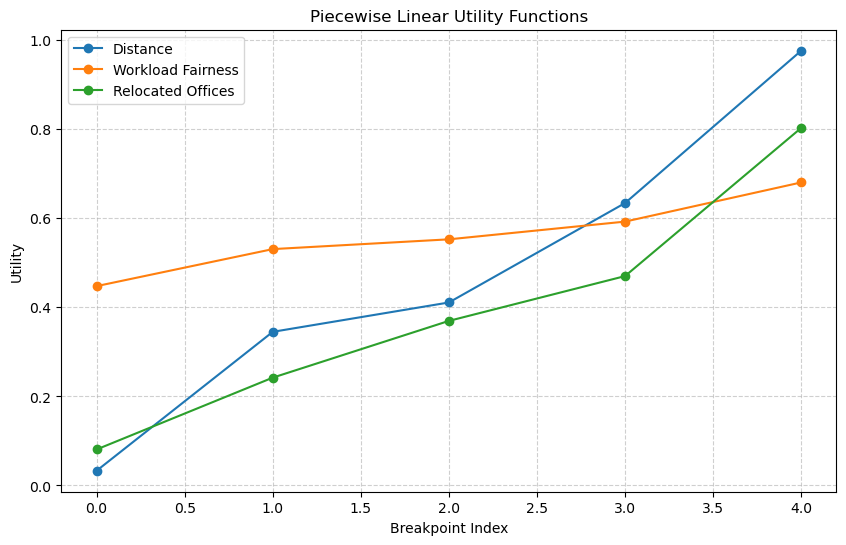

Evaluated Solutions:
       Distance  Workload Fairness  Relocated Offices   Utility
0   174.908024          19.391693                  7  1.522286
1   290.142861          15.502656                  1  1.634531
2   246.398788          18.789979                  4  1.603415
3   219.731697          17.896547                  4  1.461930
4   131.203728          11.958000                  5  1.150153
5   131.198904          18.437485                  7  1.338760
6   111.616722           1.769850                  7  1.028555
7   273.235229           3.919657                  4  1.645259
8   220.223002           0.904546                  7  1.442193
9   241.614516           6.506607                  3  1.391052
10  104.116899           7.773546                  6  0.996297
11  293.981970           5.426981                  2  1.670890
12  266.488528          16.574750                  9  2.205483
13  142.467822           7.135067                  5  1.195218
14  136.364993           5.618690

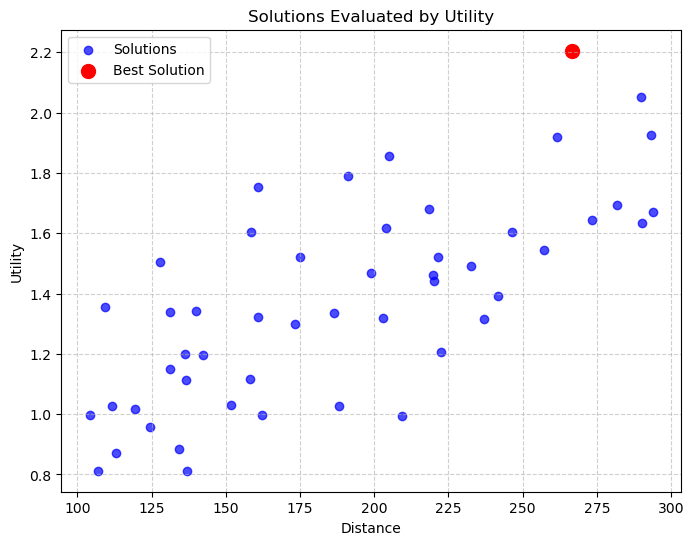

In [100]:
# Step 1: Generate simulated non-dominated solutions
def generate_non_dominated_solutions(n_solutions=50):
    """
    Simulate a set of non-dominated solutions for the three criteria.
    Each solution has values for distance, workload fairness, and relocated offices.
    """
    np.random.seed(42)
    total_distance = np.random.uniform(100, 300, n_solutions)  # Random distances
    workload_fairness = np.random.uniform(0, 20, n_solutions)  # Random fairness measures
    relocated_offices = np.random.randint(1, 10, n_solutions)  # Random office relocations
    
    solutions = pd.DataFrame({
        "Distance": total_distance,
        "Workload Fairness": workload_fairness,
        "Relocated Offices": relocated_offices
    })
    return solutions

non_dominated_solutions = generate_non_dominated_solutions()

# Step 2: Generate a random piecewise linear additive utility model
def generate_utility_functions(n_criteria=3, n_breakpoints=5):
    """
    Generate random piecewise linear utility functions for each criterion.
    Each utility is defined by `n_breakpoints` linear pieces.
    """
    utilities = []
    for _ in range(n_criteria):
        # Generate breakpoints (sorted values) and corresponding utility levels
        breakpoints = np.sort(np.random.uniform(0, 1, n_breakpoints))
        utilities.append(breakpoints)
    return utilities

utility_functions = generate_utility_functions()

# Visualize utility functions
def plot_utility_functions(utility_functions, labels):
    plt.figure(figsize=(10, 6))
    for i, utility in enumerate(utility_functions):
        plt.plot(range(len(utility)), utility, marker="o", label=labels[i])
    plt.xlabel("Breakpoint Index")
    plt.ylabel("Utility")
    plt.title("Piecewise Linear Utility Functions")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

plot_utility_functions(utility_functions, ["Distance", "Workload Fairness", "Relocated Offices"])

# Step 3: Apply the UTA method to evaluate solutions
def apply_uta(solutions, utility_functions):
    """
    Evaluate each solution using the UTA method with given utility functions.
    Normalize each criterion and compute a weighted sum of utilities.
    """
    # Normalize solutions for each criterion to [0, 1]
    normalized_solutions = solutions.copy()
    for col in solutions.columns:
        normalized_solutions[col] = (
            (solutions[col] - solutions[col].min()) /
            (solutions[col].max() - solutions[col].min())
        )
    
    # Compute utility for each solution
    total_utilities = []
    for _, row in normalized_solutions.iterrows():
        utility = 0
        for i, criterion in enumerate(row):
            utility += np.interp(criterion, np.linspace(0, 1, len(utility_functions[i])), utility_functions[i])
        total_utilities.append(utility)
    
    solutions["Utility"] = total_utilities
    return solutions

evaluated_solutions = apply_uta(non_dominated_solutions, utility_functions)

# Step 4: Select the best solution
best_solution = evaluated_solutions.loc[evaluated_solutions["Utility"].idxmax()]

# Display results
print("Evaluated Solutions:\n", evaluated_solutions)
print("\nBest Solution:\n", best_solution)

# Visualize evaluated solutions
plt.figure(figsize=(8, 6))
plt.scatter(evaluated_solutions["Distance"], evaluated_solutions["Utility"], label="Solutions", c="blue", alpha=0.7)
plt.scatter(best_solution["Distance"], best_solution["Utility"], color="red", label="Best Solution", s=100)
plt.xlabel("Distance")
plt.ylabel("Utility")
plt.title("Solutions Evaluated by Utility")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
